# Calibrating the Hugonnet Glacier Model with Altimetry Data
## Glacier Mass Balance Model Calibration Based on Satellite Altimetry Observations

**Feature Overview:**
- Read Hugonnet et al. (2021) global glacier mass balance dataset
- Extract data for High Mountain Asia (HMA)
- Calibrate model data using altimetry observations
- Apply specific correction factors for different sub-regions
- Output calibrated glacier-by-glacier mass balance data

**Data Sources:**
- Hugonnet et al. (2021) - Global glacier mass balance based on DEM differencing
- ICESat/ICESat-2/CryoSat-2 Altimetry Observations - Used for calibration

**Goal:**
Align model-estimated mass balance with altimetry observations to generate a calibrated dataset for further analysis.

## 1. Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt

print("✓ 库导入成功")


✓ 库导入成功


## 2. Data Loading

### 2.1 Load Hugonnet Global Glacier Dataset

In [2]:
# Hugonnet et al. (2021) 全球冰川质量平衡数据
# 数据说明：基于2000-2020年DEM差分计算的逐冰川质量平衡
hugonnet_path = 'E:/HMA/Hugonnet/per_glacier/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide_filled.hdf'

data = pd.read_hdf(hugonnet_path)
print(f"✓ Hugonnet数据加载成功")
print(f"  数据形状: {data.shape}")
print(f"  列名: {list(data.columns)}")
print(f"  包含区域: {sorted(data['reg'].unique())}")


✓ Hugonnet数据加载成功
  数据形状: (646641, 6)
  列名: ['period', 'area', 'dmdtda', 'err_dmdtda', 'reg', 'is_cor']
  包含区域: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)]


In [3]:
data

,period,area,dmdtda,err_dmdtda,reg,is_cor
rgiid,,,,,,
RGI60-01.00001,2000-01-01_2010-01-01,360000.0,0.021700,0.430000,1,False
RGI60-01.00001,2000-01-01_2020-01-01,360000.0,-0.012800,0.217600,1,False
RGI60-01.00001,2010-01-01_2020-01-01,360000.0,-0.047200,0.394900,1,False
RGI60-01.00002,2000-01-01_2010-01-01,558000.0,-0.168300,0.279200,1,False
RGI60-01.00002,2000-01-01_2020-01-01,558000.0,-0.229000,0.146000,1,False
...,...,...,...,...,...,...
RGI60-19.02751,2000-01-01_2020-01-01,11000.0,-0.136311,0.295265,19,True
RGI60-19.02751,2010-01-01_2020-01-01,11000.0,-0.119835,0.536447,19,True
RGI60-19.02752,2000-01-01_2010-01-01,528000.0,0.121300,0.542100,19,False


### 2.2 Filter High Mountain Asia Data

RGI (Randolph Glacier Inventory) Region Numbers:
- **Region 13**: Central Asia
- **Region 14**: South Asia West  
- **Region 15**: South Asia East

These three regions constitute High Mountain Asia (HMA).

In [4]:
# 筛选高亚洲地区的数据（RGI区域13, 14, 15）
hma = pd.concat([
    data[data['reg'] == 13],
    data[data['reg'] == 14],
    data[data['reg'] == 15]
], ignore_index=False)

print(f"✓ 高亚洲数据提取完成")
print(f"  HMA冰川数量: {len(hma.index.unique())}")
print(f"  区域13: {len(data[data['reg']==13].index.unique())} 个冰川")
print(f"  区域14: {len(data[data['reg']==14].index.unique())} 个冰川")
print(f"  区域15: {len(data[data['reg']==15].index.unique())} 个冰川")

# 查看可用的时间段
print(f"\n可用时间段:")
periods = hma['period'].unique()
for p in sorted(periods):
    count = len(hma[hma['period'] == p])
    print(f"  {p}: {count} 个冰川")


✓ 高亚洲数据提取完成
  HMA冰川数量: 95536
  区域13: 54429 个冰川
  区域14: 27988 个冰川
  区域15: 13119 个冰川

可用时间段:
  2000-01-01_2010-01-01: 95536 个冰川
  2000-01-01_2020-01-01: 95536 个冰川
  2010-01-01_2020-01-01: 95536 个冰川


### 2.3 Extract Data for Different Periods

In [5]:
# 提取三个关键时期的数据
hma0020 = hma[hma['period'] == '2000-01-01_2020-01-01'].copy()  # 2000-2020（20年）
hma0010 = hma[hma['period'] == '2000-01-01_2010-01-01'].copy()  # 2000-2010（10年）
hma1020 = hma[hma['period'] == '2010-01-01_2020-01-01'].copy()  # 2010-2020（10年）

print("✓ 时期数据提取完成")
print(f"  2000-2020: {len(hma0020)} 个冰川")
print(f"  2000-2010: {len(hma0010)} 个冰川")
print(f"  2010-2020: {len(hma1020)} 个冰川")

# 显示数据字段
print(f"\n主要字段说明:")
print(f"  dmdtda: 比质量平衡率 (m w.e./yr)")
print(f"  area: 冰川面积 (km²)")
print(f"  期间: {hma0020['period'].iloc[0] if len(hma0020) > 0 else 'N/A'}")


✓ 时期数据提取完成
  2000-2020: 95536 个冰川
  2000-2010: 95536 个冰川
  2010-2020: 95536 个冰川

主要字段说明:
  dmdtda: 比质量平衡率 (m w.e./yr)
  area: 冰川面积 (km²)
  期间: 2000-01-01_2020-01-01


### 2.4 Load Glacier Boundary Data (Including Zonal Information)

In [6]:
# 加载RGI冰川边界（包含O1Region和O2Region分区信息）
glacier_path = "E:/HMA/Hugonnet/per_glacier/rgi_hma.shp"

glacier = gpd.read_file(glacier_path)
print(f"✓ 冰川边界数据加载成功")
print(f"  冰川数量: {len(glacier)}")
print(f"  包含字段: {list(glacier.columns[:10])}...")

# 查看分区信息
if 'O1Region' in glacier.columns and 'O2Region' in glacier.columns:
    o1_unique = glacier['O1Region'].unique()
    o2_unique = glacier['O2Region'].unique()
    print(f"  O1Region (一级分区): {sorted([x for x in o1_unique if pd.notna(x)])}")
    print(f"  O2Region (二级分区): {sorted([x for x in o2_unique if pd.notna(x)])}")


✓ 冰川边界数据加载成功
  冰川数量: 95536
  包含字段: ['RGIId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat', 'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax']...
  O1Region (一级分区): ['13', '14', '15']
  O2Region (二级分区): ['1', '2', '3', '4', '5', '6', '7', '8', '9']


In [7]:
# hma22子区域测高change rate
hma22_shp = r'E:\HMA_subregion\regions_hma_v03_zheng\boundary_mountain_regions_hma_v3_zheng_20200601.shp'
hma_one_shp = r'E:\HMA\HMA_boundary\HMA_one.shp'
hma22 = gpd.read_file(hma22_shp)
hma_one = gpd.read_file(hma_one_shp)

trend_results = pd.read_excel(r'E:\revised_NCC_data\ICESat2_result\ICESat2_HMAsubregion_trend.xlsx', index_col=0)
print('区域数目', len(trend_results))

区域数目 39


## 3. Calibration Parameter Settings

Define correction factors for different sub-regions based on altimetry observations.

In [8]:
corrected_df = pd.DataFrame(
    columns = ['Hugonnet_merge_mb0020'],
    index = ['HMA']+hma22['Name'].tolist(),
)

# 检查并统一坐标系
if glacier.crs != hma_one.crs:
    glacier = glacier.to_crs(hma_one.crs)

glacier_in = gpd.sjoin(glacier, hma_one, how='inner', predicate='within')
selected_glaciers = hma0020.loc[glacier_in['RGIId'], :]
mb_merge = (selected_glaciers['dmdtda']*selected_glaciers['area']).dropna()
mb_merge_final = mb_merge.sum()/(selected_glaciers.loc[mb_merge.index, 'area'].sum())

corrected_df.loc['HMA', 'Hugonnet_merge_mb0020'] = mb_merge_final #mwse/yr

if glacier.crs != hma22.crs:
    glacier = glacier.to_crs(hma22.crs)
    
for idx, hma22_row in hma22.iterrows():
    hma22_name = hma22_row['Name']
    hma22_single = hma22.loc[[idx]]

    glacier_in = gpd.sjoin(glacier, hma22_single, how='inner', predicate='within')
    if len(glacier_in)>0:
        selected_glaciers = hma0020.loc[glacier_in['RGIId'], :]
        mb_merge = (selected_glaciers['dmdtda']*selected_glaciers['area']).dropna()
        mb_merge_final = mb_merge.sum()/(selected_glaciers.loc[mb_merge.index, 'area'].sum())  

        corrected_df.loc[hma22_name, 'Hugonnet_merge_mb0020'] = mb_merge_final

In [9]:
corrected_df['Hugonnet_merge_ice0020'] = corrected_df['Hugonnet_merge_mb0020']/0.85
corrected_df['our_ice0020'] = np.nan
corrected_df['our_ice0024'] = np.nan

corrected_df.loc['HMA', 'our_ice0020'] = trend_results.iloc[0]['k00to20']
corrected_df.loc['HMA', 'our_ice0024'] = trend_results.iloc[0]['k00to24']

count = 0
for idx, hma22_row in hma22.iterrows():
    hma22_name = hma22_row['Name']
    
    corrected_df.loc[hma22_name, 'our_ice0020'] = trend_results.iloc[16+count]['k00to20']
    corrected_df.loc[hma22_name, 'our_ice0024'] = trend_results.iloc[16+count]['k00to24']
    count += 1

corrected_df['factor_0020'] = corrected_df['our_ice0020']/corrected_df['Hugonnet_merge_ice0020']
corrected_df['factor_0024'] = corrected_df['our_ice0024']/corrected_df['Hugonnet_merge_ice0020']

In [10]:
corrected_df

,Hugonnet_merge_mb0020,Hugonnet_merge_ice0020,our_ice0020,our_ice0024,factor_0020,factor_0024
HMA,-0.215608,-0.253657,-0.280479,-0.318719,1.105741,1.256497
Alataw Shan,-0.52509,-0.617752,-0.750648,-0.752538,1.215127,1.218187
E Tien Shan,-0.467771,-0.550319,-0.677783,-0.705029,1.231619,1.281129
N/W Tien Shan,-0.348846,-0.410407,-0.437421,-0.433046,1.065823,1.055162
C Tien Shan,-0.215046,-0.252995,-0.169705,-0.200163,0.670782,0.791174
Alay,-0.103202,-0.121414,-0.243181,-0.320834,2.002903,2.642467
Qilian Shan,-0.289237,-0.340279,-0.632908,-0.648147,1.859969,1.904753
Altun Shan,-0.039306,-0.046242,-0.139128,-0.176689,3.008674,3.820941
E Pamir,0.04118,0.048447,0.022281,-0.003540,0.459908,-0.073073
W Pamir,-0.118477,-0.139385,-0.239828,-0.272835,1.720617,1.957417


### 3.1 Calibration Method Description

**Calibration Principle:**

1. **Altimetry observations** provide regional mean elevation change rates (dhda_altimetry).
2. **Hugonnet model** provides glacier-by-glacier mass balance rates (dmdtda).
3. Calculate the area-weighted mean of the model for each sub-region.
4. Adjust model results to match altimetry observations using correction factors.

**Formula:**
Calibrated Mass Balance = Original Model Mass Balance × Correction Factor


**Correction Factor Calculation:**
Correction Factor = Altimetry Observation / Model Regional Mean


This maintains the spatial distribution pattern of the model while aligning th

## 4. Data Calibration Processing

### 4.1 Define Calibration Function

In [11]:
def calibrate_subregion(glacier_gdf, hma_mb, hma22_row, 
                        calibration_df, calibrate_column, new_period='2000-01-01_2020-01-01'):
    # 筛选子区域的冰川
    subregion_glaciers = glacier_gdf.clip(hma22_row)
    rgi_ids = set(subregion_glaciers['RGIId'])
    
    # 从Hugonnet数据中筛选该子区域的冰川
    subregion_data = hma_mb[(hma_mb.index.isin(rgi_ids)) & (hma_mb['if_corrected'] == 0)].copy()
    
    # 计算原始模型的区域平均质量平衡（面积加权）
    if len(subregion_data) > 0:
        temp_data = (subregion_data['area'] * subregion_data['dmdtda']).dropna()
        # 添加分母检查，避免除以零
        area_sum = subregion_data.loc[temp_data.index, 'area'].sum()
        if area_sum > 0:
            region_mean = temp_data.sum() / area_sum
        else:
            region_mean = np.nan
    else:
        region_mean = np.nan
    
    # 应用校正因子
    if len(subregion_data) > 0:
        subregion_data['dmdtda'] = subregion_data['dmdtda'] * calibration_df.loc[hma22_row['Name'].iloc[0], calibrate_column]
        temp_data = (subregion_data['area'] * subregion_data['dmdtda']).dropna()
        
        # 添加分母检查，避免除以零
        area_sum = subregion_data.loc[temp_data.index, 'area'].sum()
        if area_sum > 0:
            updated_mean = temp_data.sum() / area_sum
        else:
            updated_mean = np.nan
        
        # 应用校正并确保类型正确
        correction_factor = calibration_df.loc[hma22_row['Name'].iloc[0], calibrate_column]
        corrected_values = hma_mb.loc[subregion_data.index, 'dmdtda'] * correction_factor
        
        # 使用astype确保类型一致
        hma_mb.loc[subregion_data.index, 'dmdtda'] = corrected_values.astype(float)
        hma_mb.loc[subregion_data.index, 'if_corrected'] = 1
    else:
        updated_mean = np.nan
    
    # 更新时期标识
    hma_mb['period'] = new_period
    
    return hma_mb, region_mean, updated_mean

### 4.2 Batch Calibrate All Sub-Regions

In [12]:
# 初始化结果数据框（从hma0020复制一份作为起始）
calibrated_data0020 = hma0020.copy()
calibrated_data0024 = hma0020.copy()
calibrated_data0020['if_corrected'] = 0
calibrated_data0024['if_corrected'] = 0

# 存储校准统计信息
calibration_stats = []

for idx, hma22_row in hma22.iterrows():
    hma22_name = hma22_row['Name']
    hma22_single = hma22.loc[[idx]]
    calibrated_data0020, region_mean0020, updated_mean0020 = calibrate_subregion(glacier, calibrated_data0020, hma22_single, 
                        corrected_df, 'factor_0020', new_period='2000-01-01_2020-01-01')

    calibrated_data0024, _, updated_mean0024 = calibrate_subregion(glacier, calibrated_data0024, hma22_single, 
                        corrected_df, 'factor_0024', new_period='2000-01-01_2024-01-01')
    
    # 保存统计信息
    calibration_stats.append({
        'name': hma22_name,
        'Model_Original': region_mean0020,
        'Calibration_Factor0020': corrected_df.loc[hma22_name, 'factor_0020'],
        'Model_Calibrated0020': updated_mean0020,
        'altimetry_obs0020': corrected_df.loc[hma22_name, 'our_ice0020']*0.85,
        'Calibration_Factor0024': corrected_df.loc[hma22_name, 'factor_0024'],
        'Model_Calibrated0024': updated_mean0024,
        'altimetry_obs0024': corrected_df.loc[hma22_name, 'our_ice0024']*0.85,
    })
    

print(f"✓ 校准完成！")
print(f"  校准后数据总量: {len(calibrated_data0024)} 条记录")


✓ 校准完成！
  校准后数据总量: 95536 条记录


In [13]:
calibration_stats

[{'name': 'Alataw Shan',
  'Model_Original': np.float64(-0.5250895704915418),
  'Calibration_Factor0020': np.float64(1.215127238496187),
  'Model_Calibrated0020': np.float64(-0.6380506397545362),
  'altimetry_obs0020': np.float64(-0.6380506397545362),
  'Calibration_Factor0024': np.float64(1.218187350881764),
  'Model_Calibrated0024': np.float64(-0.6396574728527346),
  'altimetry_obs0024': np.float64(-0.6396574728527347)},
 {'name': 'E Tien Shan',
  'Model_Original': np.float64(-0.46777100247809084),
  'Calibration_Factor0020': np.float64(1.2316190916160301),
  'Model_Calibrated0020': np.float64(-0.5761156971563859),
  'altimetry_obs0020': np.float64(-0.576115697156386),
  'Calibration_Factor0024': np.float64(1.281129136376861),
  'Model_Calibrated0024': np.float64(-0.599275060426895),
  'altimetry_obs0024': np.float64(-0.5992750604268952)},
 {'name': 'N/W Tien Shan',
  'Model_Original': np.float64(-0.3488458405979158),
  'Calibration_Factor0020': np.float64(1.0658228326221264),
  'Mod

## 6. Data Export

### 6.1 Export Calibrated Data to HDF File

In [ ]:
# 输出路径
output_path = r'E:\revised_NCC_data\OGGM model\preparation\Altimetrymb_rgiregion_result_for_OGGM0020.hdf'

# 保存校准后的数据
calibrated_data0020.to_hdf(output_path, key='subregionhdf', mode='w')

In [3]:
output_path = r'E:\revised_NCC_data\OGGM model\preparation\Altimetrymb_rgiregion_result_for_OGGM0020.hdf'
calibrated_data0020 = pd.read_hdf(output_path)

# 保存为CSV
calibrated_data0020.to_csv(output_path.replace('.hdf', '.csv'))

In [14]:
# 输出路径
output_path = r'E:\revised_NCC_data\OGGM model\preparation\Altimetrymb_rgiregion_result_for_OGGM0024.hdf'

# 保存校准后的数据
calibrated_data0024.to_hdf(output_path, key='subregionhdf', mode='w')

In [15]:
output_path = r'E:\revised_NCC_data\OGGM model\preparation\Altimetrymb_rgiregion_result_for_OGGM0024.hdf'
calibrated_data0024 = pd.read_hdf(output_path)

# 保存为CSV
calibrated_data0024.to_csv(output_path.replace('.hdf', '.csv'))

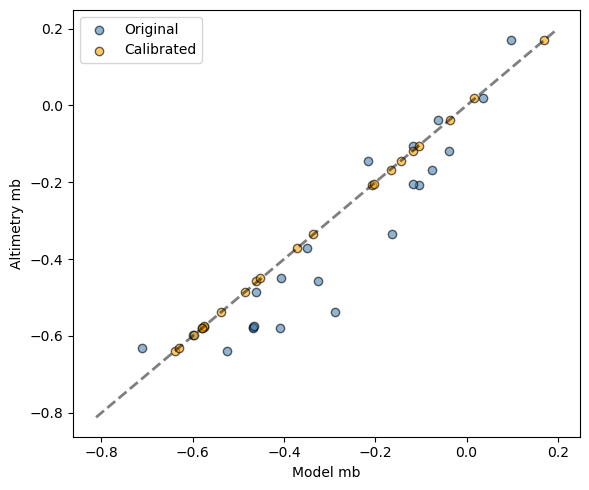

In [ ]:
# compare models and altimetry
stats_df = pd.DataFrame(calibration_stats)

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(stats_df['Model_Original'], stats_df['altimetry_obs0020'], 
           alpha=0.6, c='steelblue', 
          edgecolors='black', linewidth=1, label='Original')

ax.scatter(stats_df['Model_Calibrated0020'], stats_df['altimetry_obs0020'], 
          alpha=0.6, c='orange', 
          edgecolors='black', linewidth=1, label='Calibrated')

lim_min = stats_df['Model_Original'].min() - 0.1
lim_max = stats_df['Model_Original'].max() + 0.1
ax.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', 
        linewidth=2, alpha=0.5)
ax.set_xlabel('Model mb')
ax.set_ylabel('Altimetry mb')
plt.legend()

plt.tight_layout()
plt.show()

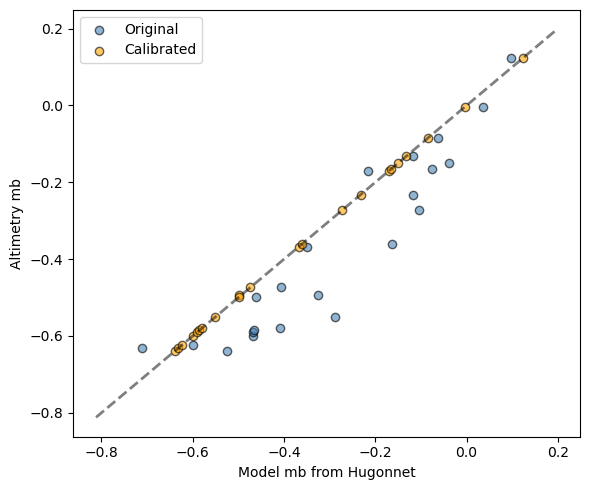

In [16]:
# compare models and altimetry
stats_df = pd.DataFrame(calibration_stats)

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(stats_df['Model_Original'], stats_df['altimetry_obs0024'], 
           alpha=0.6, c='steelblue', 
          edgecolors='black', linewidth=1, label='Original')

ax.scatter(stats_df['Model_Calibrated0024'], stats_df['altimetry_obs0024'], 
          alpha=0.6, c='orange', 
          edgecolors='black', linewidth=1, label='Calibrated')

lim_min = stats_df['Model_Original'].min() - 0.1
lim_max = stats_df['Model_Original'].max() + 0.1
ax.plot([lim_min, lim_max], [lim_min, lim_max], 'k--', 
        linewidth=2, alpha=0.5)
ax.set_xlabel('Model mb from Hugonnet')
ax.set_ylabel('Altimetry mb')
plt.legend()

plt.tight_layout()
plt.show()